# Determine if Market Segments Behave Differently

In [2]:
target_cols = [
    # 'unique_id',
    'weight_departing_only',
    'purpose_segment', # WSP's constructed trip characteristic, w/ employee logic included

    'age',
    'age_label',
    'gender',
    'gender_label',
    'occupation', # only for employees
    'occupation_label', # only for employees
    'household_income',
    'household_income_label',

    'passenger_segment',
    'passenger_segment_label',
    'resident_visitor',
    'resident_visitor_label',

    'flight_purpose',
    'flight_purpose_label',
    'car_available',
    'car_available_label',

# survey trip characteristics
   'main_mode',
   'main_mode_label',
   'trip_arrival_time',
   'trip_arrival_time_label',
#    'airline',
#    'airline_label',
   'nights_away',
   'nights_away_label',
   'airport_terminal',
   'convention_center',
   'convention_center_label',
#    'convention_center_activity',
#    'convention_center_activity_label',
   'party_size_transformed', # constructed trip characteristic
   'party_size_label_transformed', # constructed trip characteristic
   'parking_cost_numeric', # has NULL values # only for employees
   'parking_location', # only for employees
   'parking_location_label', # only for employees
#    'parking_location_other',

   # respondent TAZs
   'origin_taz',
    'origin_latitude',
    'origin_longitude',
   'destination_taz',
    'destination_latitude',
    'destination_longitude',
#    'home_location_taz',
#    'transit_alighting_taz',
#    'transit_boarding_taz',

   # trip data from 2022 base scenario skims
   'auto_dist', 'auto_time', 'auto_tollcost',
   'pnrin_loc_fare', 'pnrin_mix_fare', 'pnrin_prm_fare',
   'pnrin_loc_time', 'pnrin_mix_time', 'pnrin_prm_time',
   'walk_loc_fare', 'walk_mix_fare', 'walk_prm_fare',
   'walk_loc_time', 'walk_mix_time',  'walk_prm_time',

   # TNC/taxi columns - mix of survey and constructed data
   'taxi_fhv_fare_numeric', # fare
   'taxi_fare_model',
   'tnc_fare_model',
   'taxi_fhv_wait_numeric', # wait
   'taxi_mean_wait_model',
   'tnc_mean_wait_model',

    ]

## Set-Up

In [113]:
import matplotlib.pyplot as plt
import geoplot as glpt
import seaborn as sns

import geopandas as gpd
import pandas as pd

In [ ]:
survey_data_path = r'..\..\data\processed\data_model_output_full_pii_taz.csv'

In [5]:
survey_data = (
    pd.read_csv(
        survey_data_path,
        usecols=target_cols
        )
    .query('weight_departing_only.notna()')
)

survey_data['res_vs_vis'] = survey_data['purpose_segment'].str.lower().str.contains('resident').astype(int)
survey_data.loc[survey_data['purpose_segment'].str.lower()=='employee','res_vs_vis'] = 2
survey_data['bus_vs_non_bus'] = survey_data['purpose_segment'].str.lower().str.contains('non_business')

C:\Users\mwe\AppData\Local\Temp\ipykernel_22264\3627981321.py:2: DtypeWarning: Columns (48,170,196) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


In [6]:
print(f'Number of Respondents: {survey_data.shape[0]}')
survey_data.isna().sum()[survey_data.isna().sum() > 0].sort_values(ascending=False)

Number of Respondents: 4839


parking_cost_numeric            4233
parking_location                4206
parking_location_label          4206
occupation                      4180
occupation_label                4180
pnrin_mix_time                  3810
taxi_fhv_wait_numeric           3345
car_available                   3322
car_available_label             3322
taxi_fhv_fare_numeric           3297
nights_away_label               3127
nights_away                     3127
walk_mix_time                   2719
convention_center               2413
convention_center_label         2413
pnrin_prm_time                  1716
walk_prm_time                   1716
taxi_mean_wait_model             975
tnc_mean_wait_model              975
airport_terminal                 659
flight_purpose                   659
flight_purpose_label             659
passenger_segment                659
passenger_segment_label          659
party_size_transformed           659
party_size_label_transformed     659
pnrin_loc_time                   521
w

In [7]:
mode_map = {
        'DROVE_ALONE_AND_PARKED': 'DROVE_ALONE', 'GET_IN_PARKED_VEHICLE_AND_DRIVE_ALONE': 'DROVE_ALONE',
        'DROPPED_OFF_BY_FAMILY_FRIEND': 'DRIVEN_BY_FAMILY_FRIEND', 'PICKED_UP_BY_FAMILY_FRIEND': 'DRIVEN_BY_FAMILY_FRIEND',
        'DROVE_WITH_OTHERS_AND_PARKED': 'DROVE_WITH_OTHERS', 'GET_IN_PARKED_VEHICLE_AND_DRIVE_WITH_OTHERS': 'DROVE_WITH_OTHERS', 'RODE_WITH_OTHER_TRAVELERS_AND_PARKED': 'DROVE_WITH_OTHERS',
        'HOTEL_SHUTTLE_VAN': 'SHUTTLE/VAN/CHARTERED_BUS', 'CHARTERED_TOUR_BUS': 'SHUTTLE/VAN/CHARTERED_BUS', 'OTHER_SHARED_VAN': 'SHUTTLE/VAN/CHARTERED_BUS',
        'MTS_ROUTE_992': 'TRANSIT', 'AIRPORT_FLYER_SHUTTLE': 'TRANSIT', 'OTHER_PUBLIC_TRANSIT': 'TRANSIT',
        'TAXI': 'TAXI/TNC', 'UBER_LYFT': 'TAXI/TNC', 'CAR_SERVICE_BLACK_LIMO': 'TAXI/TNC',
        'BICYCLE_PERSONAL_NON_ELECTRIC': 'WALK/BIKE', 'BICYCLE_PERSONAL_ELECTRIC': 'WALK/BIKE', 'BICYCLE_NON_ELECTRIC_BIKESHARE': 'WALK/BIKE', 'E_SCOOTER_PERSONAL': 'WALK/BIKE', 'WALK': 'WALK/BIKE',
        'RENTAL_CAR_DROPPED_OFF':'RENTAL_CAR', 'RENTAL_CAR_PARKED':'RENTAL_CAR', 'RENTAL_CAR_PICKED_UP':'RENTAL_CAR',
        # 'OTHER',
}

### Data Transformations

In [8]:
# TODO: differentiate survey responses between LOC, MIX, PRM
# TODO simplify modes
survey_data['main_mode_label'].unique()

array(['DROVE_ALONE_AND_PARKED', 'MTS_ROUTE_992',
       'GET_IN_PARKED_VEHICLE_AND_DRIVE_WITH_OTHERS',
       'AIRPORT_FLYER_SHUTTLE', 'UBER_LYFT',
       'DROPPED_OFF_BY_FAMILY_FRIEND', 'HOTEL_SHUTTLE_VAN',
       'DROVE_WITH_OTHERS_AND_PARKED', 'WALK', 'CAR_SERVICE_BLACK_LIMO',
       'PICKED_UP_BY_FAMILY_FRIEND', 'OTHER_PUBLIC_TRANSIT',
       'GET_IN_PARKED_VEHICLE_AND_DRIVE_ALONE',
       'BICYCLE_PERSONAL_ELECTRIC', 'RENTAL_CAR_PARKED',
       'RENTAL_CAR_DROPPED_OFF', 'TAXI', 'BICYCLE_PERSONAL_NON_ELECTRIC',
       'E_SCOOTER_PERSONAL', 'BICYCLE_NON_ELECTRIC_BIKESHARE', 'OTHER',
       'OTHER_SHARED_VAN', 'CHARTERED_TOUR_BUS',
       'RODE_WITH_OTHER_TRAVELERS_AND_PARKED', 'RENTAL_CAR_PICKED_UP'],
      dtype=object)

## Charts

In [9]:
# plt.figure(figsize=(20,20))
# sns.scatterplot(
#     data = survey_data.query('purpose_segment == "EMPLOYEE"'),
#     x = 'auto_time',
#     y = 'pnrin_mix_time',
#     hue = 'main_mode_label'
# )
# plt.legend(loc='right')
# plt.show()

### Party Size
non-business travelers tend to have larger party size

In [10]:
survey_party = survey_data.copy()

<Figure size 1500x1000 with 0 Axes>

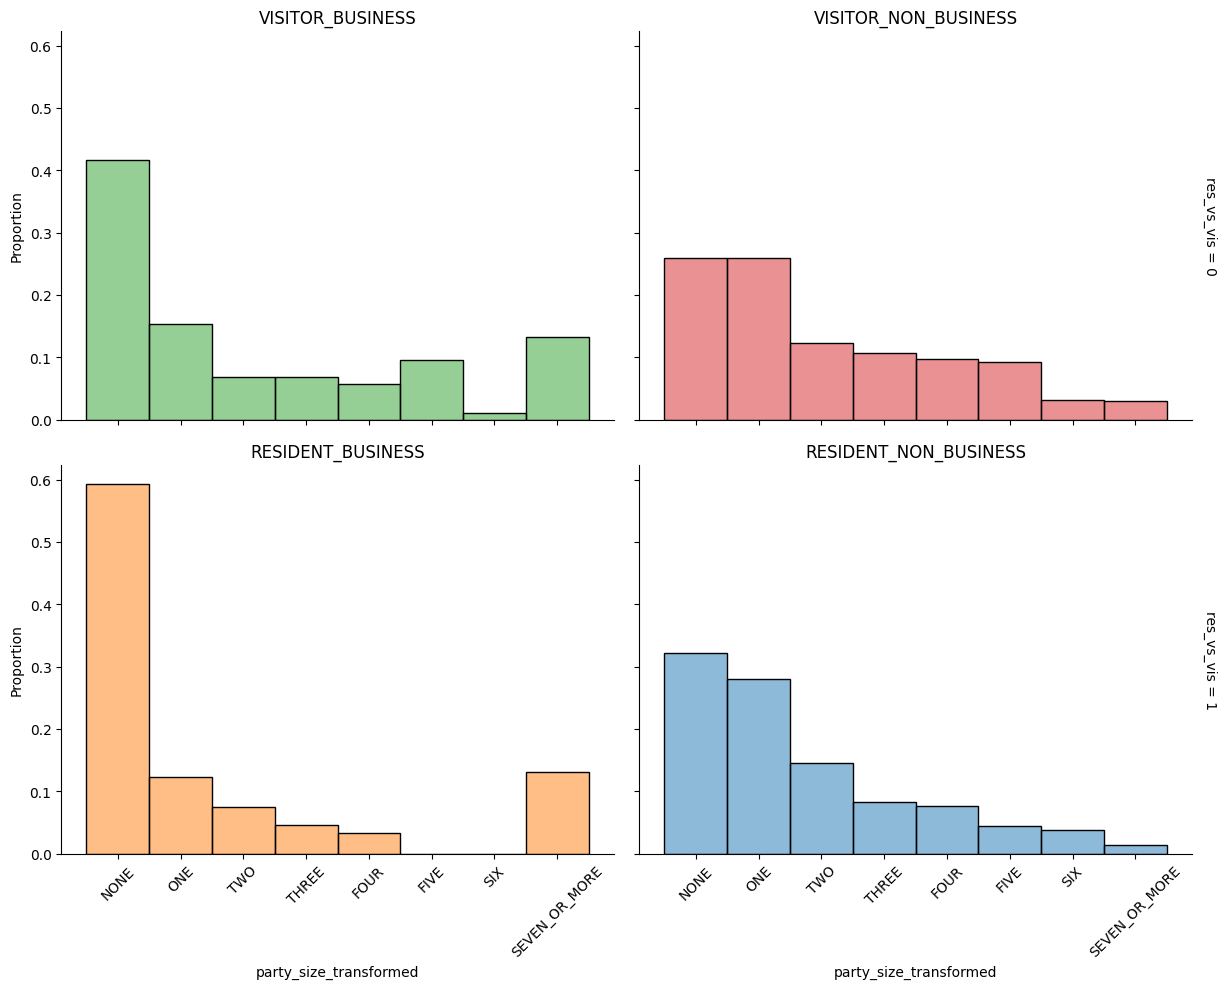

In [11]:

plt.figure(figsize=(15,10))
g = sns.displot(
    data = survey_party.query('purpose_segment.str.lower() != "employee"'),
    hue = 'purpose_segment',
    row = 'res_vs_vis',
    col = 'bus_vs_non_bus',
    x = 'party_size_transformed',
    weights = 'weight_departing_only',
    facet_kws=dict(margin_titles=True),
    stat = 'proportion',
    common_norm = False,
    discrete = True
)
order = ['VISITOR_BUSINESS', 'VISITOR_NON_BUSINESS',
   'RESIDENT_BUSINESS', 'RESIDENT_NON_BUSINESS', 'EMPLOYEE']
for idx,ax in enumerate(g.axes.flat):
    ax.set_title(order[idx])

xticks = survey_party[['party_size_transformed','party_size_label_transformed']].drop_duplicates().sort_values('party_size_transformed')
plt.xticks(ticks = xticks['party_size_transformed'].tolist()[:-1])
g.set_xticklabels(
    xticks['party_size_label_transformed'].tolist()[:-1],
    rotation=45
    )

g.figure.tight_layout()
g._legend.remove()

plt.show()

#### Rental Cars
- % using rental car mode

In [12]:
rental_modes = ['RENTAL_CAR_PARKED','RENTAL_CAR_DROPPED_OFF', 'RENTAL_CAR_PICKED_UP']
rental_car_analysis = survey_data.copy()#.query('purpose_segment != "EMPLOYEE"')
purpose_segment_total_weight = (
        rental_car_analysis
            .groupby('purpose_segment')
            ['weight_departing_only']
            .sum()
)

In [13]:
(
    rental_car_analysis
    .query(f"main_mode_label.isin({rental_modes})")
    .groupby('purpose_segment')
    ['weight_departing_only']
    .sum()
) / purpose_segment_total_weight

purpose_segment
EMPLOYEE                 0.003384
RESIDENT_BUSINESS        0.008158
RESIDENT_NON_BUSINESS    0.013287
VISITOR_BUSINESS         0.175751
VISITOR_NON_BUSINESS     0.356378
Name: weight_departing_only, dtype: float64

#### Mode

In [14]:
survey_modes = survey_data.copy()
survey_modes['mapped_modes'] = survey_modes['main_mode_label'].replace(mode_map)
# survey_modes['mapped_modes'].value_counts()

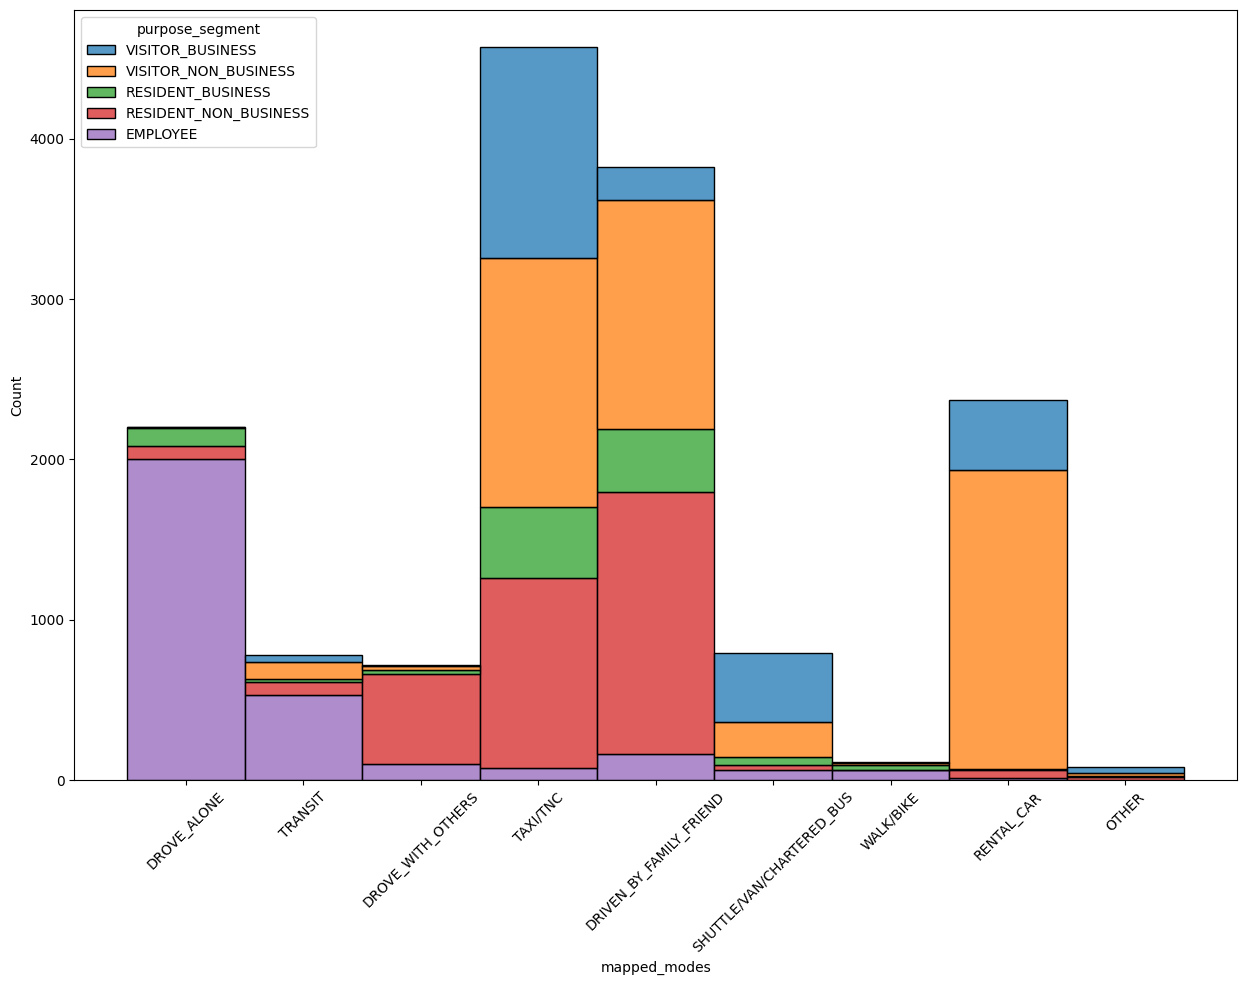

In [15]:

# sns violinplot DOES NOT HAVE weight
plt.figure(figsize=(15,10))
# g = sns.displot(
g = sns.histplot(
    data = survey_modes,
    hue = 'purpose_segment',
    multiple= 'stack',
    x = 'mapped_modes',
    weights = 'weight_departing_only',
    stat = 'count',
    common_bins = False,
    hue_order= ['VISITOR_BUSINESS', 'VISITOR_NON_BUSINESS',
                'RESIDENT_BUSINESS', 'RESIDENT_NON_BUSINESS', 'EMPLOYEE']
)
plt.xticks(rotation = 45)

plt.show()

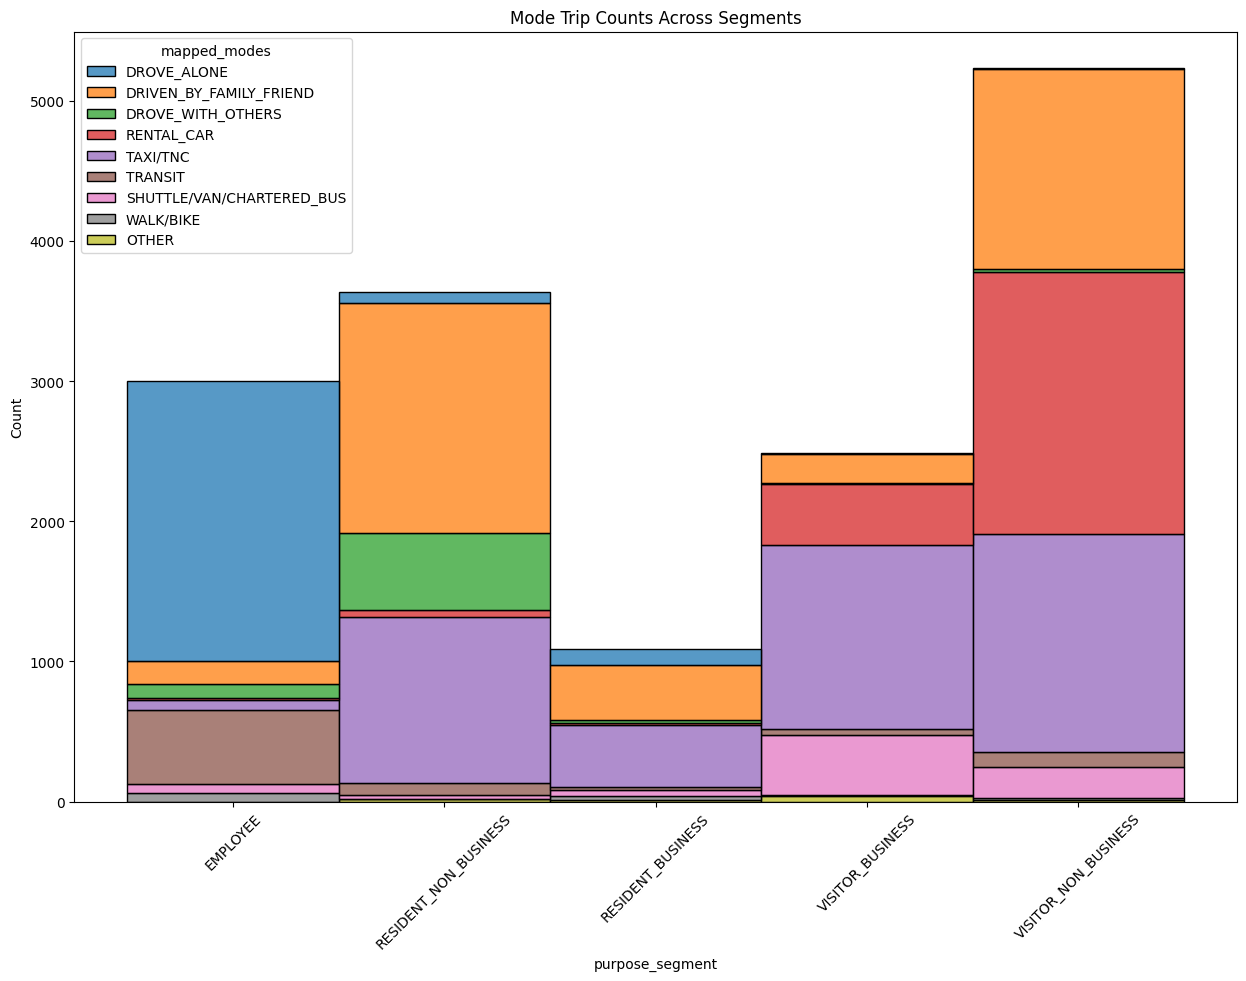

In [58]:
mapped_modes_hue_order = [
    'DROVE_ALONE',
    'DRIVEN_BY_FAMILY_FRIEND',
    'DROVE_WITH_OTHERS',
    'RENTAL_CAR',
    'TAXI/TNC',
    'TRANSIT',
    'SHUTTLE/VAN/CHARTERED_BUS',
    'WALK/BIKE',
    'OTHER',]

plt.figure(figsize=(15,10))
g = sns.histplot(
    data = survey_modes,
    x = 'purpose_segment',
    multiple= 'stack',
    hue = 'mapped_modes',
    hue_order= mapped_modes_hue_order,
    weights = 'weight_departing_only',
    palette = sns.color_palette("tab10", len(mapped_modes_hue_order)),
    # stat = 'count',
    # common_bins = False,
    # discrete = True
)
plt.title('Mode Trip Counts Across Segments')
plt.xticks(rotation = 45)

# g.add_legend(label_order = mapped_modes_hue_order[::-1])

# handles, labels = g.get_legend_handles_labels()
# sns.move_legend(g, loc='right', bbox_to_anchor=(1.25, .5))
# g.legend(handles[::-1], labels[::-1])

plt.show()

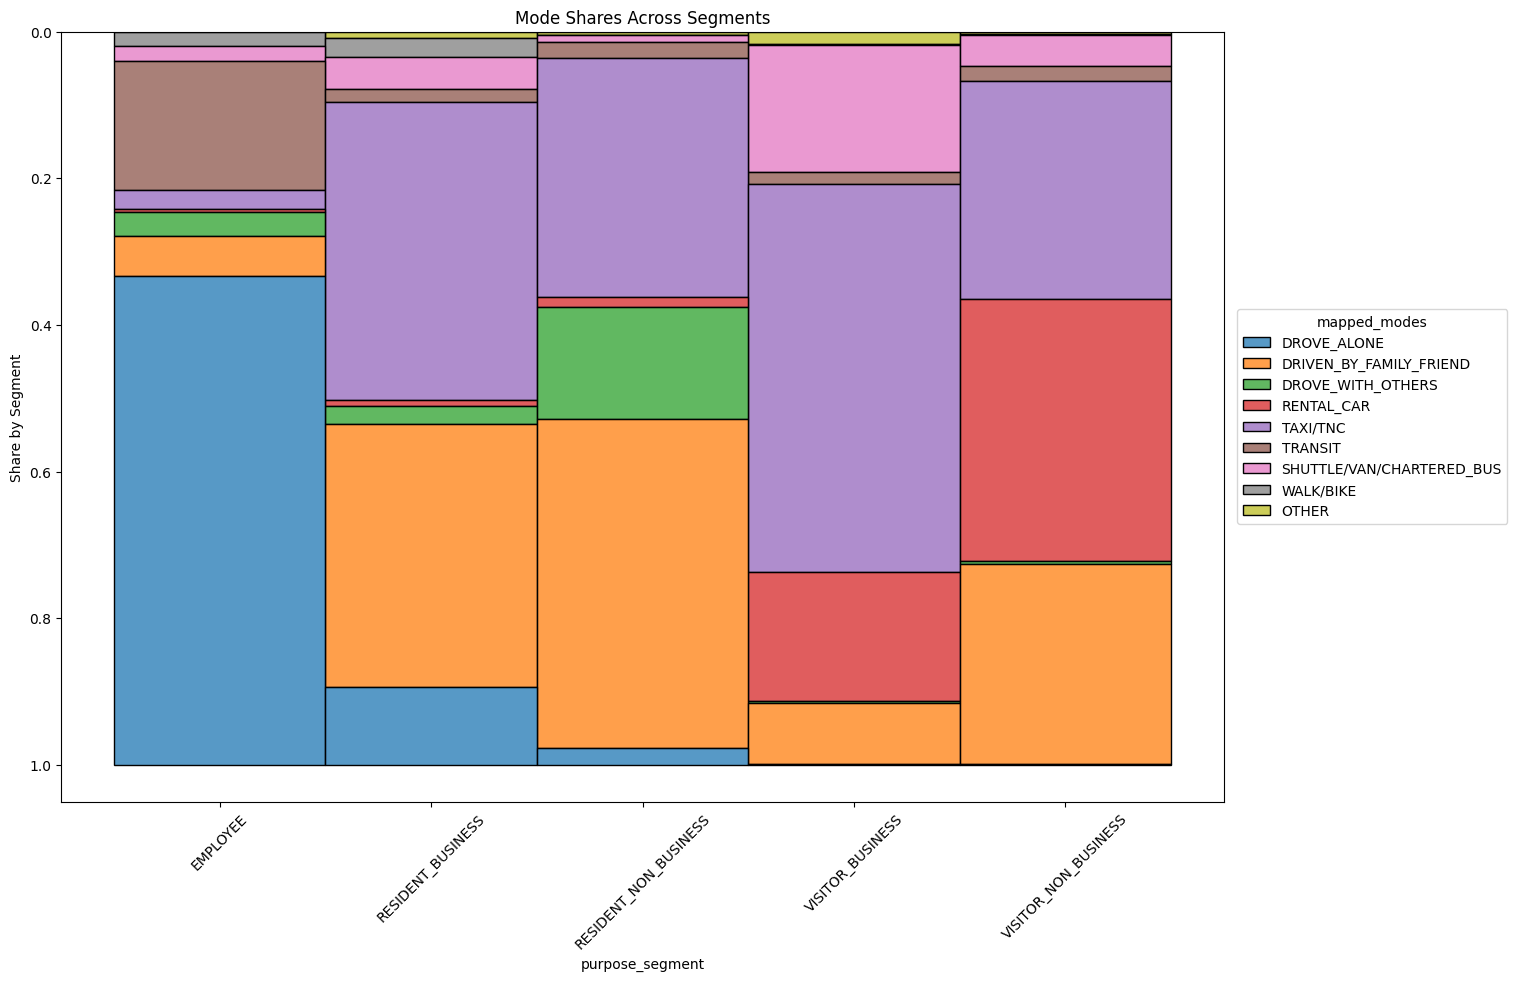

In [55]:
mode_share_by_purpose = (
    (survey_modes.groupby(['purpose_segment','mapped_modes'])['weight_departing_only'].sum()
     /survey_modes.groupby('purpose_segment')['weight_departing_only'].sum())
    .reset_index()
)

plt.figure(figsize=(15,10))
g = sns.histplot(
    data = mode_share_by_purpose,
    x = 'purpose_segment',
    multiple= 'stack',
    hue = 'mapped_modes',
    hue_order= mapped_modes_hue_order,
    weights = 'weight_departing_only',
    # stat='percent'
)
plt.title('Mode Shares Across Segments')
plt.ylabel('Share by Segment')
plt.xticks(rotation = 45)
sns.move_legend(g, loc='right', bbox_to_anchor=(1.25, .5))

g.invert_yaxis()

plt.show()

### Geographic HeatMaps

In [76]:
survey_crs = "EPSG:4326"
var_prefix = 'origin'

geography_file = f"T:/projects/sr15/geographies/TAZ15.shp"

In [116]:
geographies = (
    gpd.read_file(geography_file)
    [['TAZ','geometry']]
    .rename(columns={'TAZ': f'{var_prefix}_taz'})
)

In [117]:
survey_gdf =gpd.GeoDataFrame(
                survey_data,
                geometry=gpd.points_from_xy(
                    survey_data[f"{var_prefix}_longitude"],
                    survey_data[f"{var_prefix}_latitude"]
                ),
                crs=survey_crs,
            ).to_crs(geographies.crs)

In [118]:
# survey_gdf = (
#     survey_data
#     .merge(
#         geographies,
#         on = f'{var_prefix}_taz'
#     )
# )
# survey_gdf.columns = [col.lower() for col in survey_gdf.columns]

In [119]:
# for purp in ['VISITOR_BUSINESS', 'VISITOR_NON_BUSINESS',
#              'RESIDENT_BUSINESS', 'RESIDENT_NON_BUSINESS', 'EMPLOYEE']:

#     _, ax = plt.subplots(figsize=(20, 20))

#     geographies.boundary.plot(ax = ax, color = 'gray', alpha = .05)

#     purp_survey_gdf = gpd.GeoDataFrame(
#         survey_gdf
#             .query(f'purpose_segment.str.upper() != "{purp}"')
#             .groupby([f'{var_prefix}_taz','geometry'])
#             ['weight_departing_only']
#             .sum()
#             .reset_index()
#             .drop(columns=['origin_taz'])
#         ,crs= geographies.crs
#     )
#     purp_survey_gdf.plot(ax = ax, column = 'weight_departing_only',scheme='quantiles', alpha = 1, legend= True)

#     plt.xlim((6.15e6,6.55e6))
#     plt.ylim((1.77e6,2.15e6))
#     plt.show()

#     break

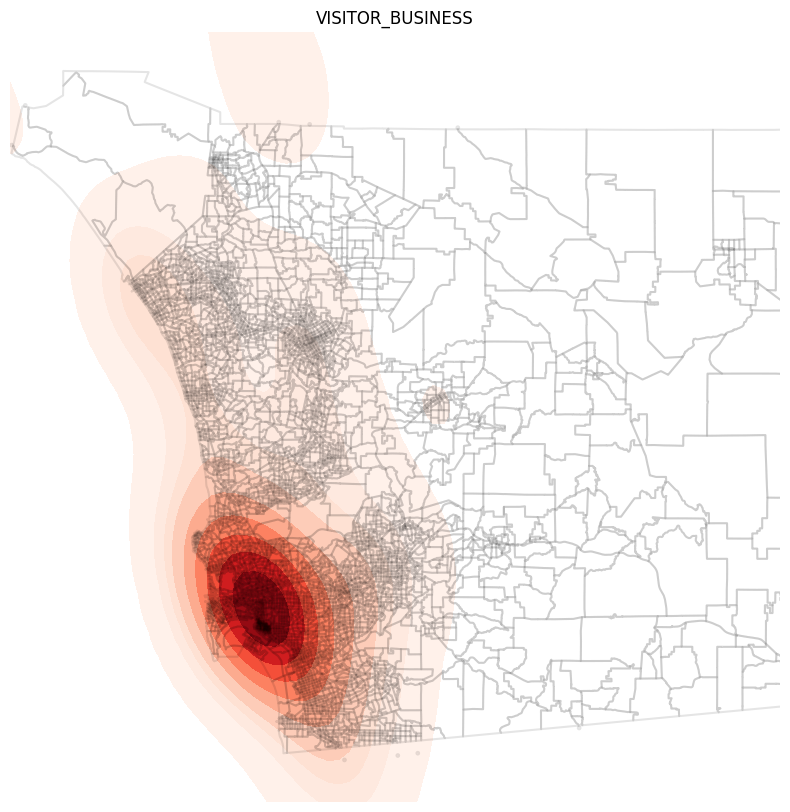

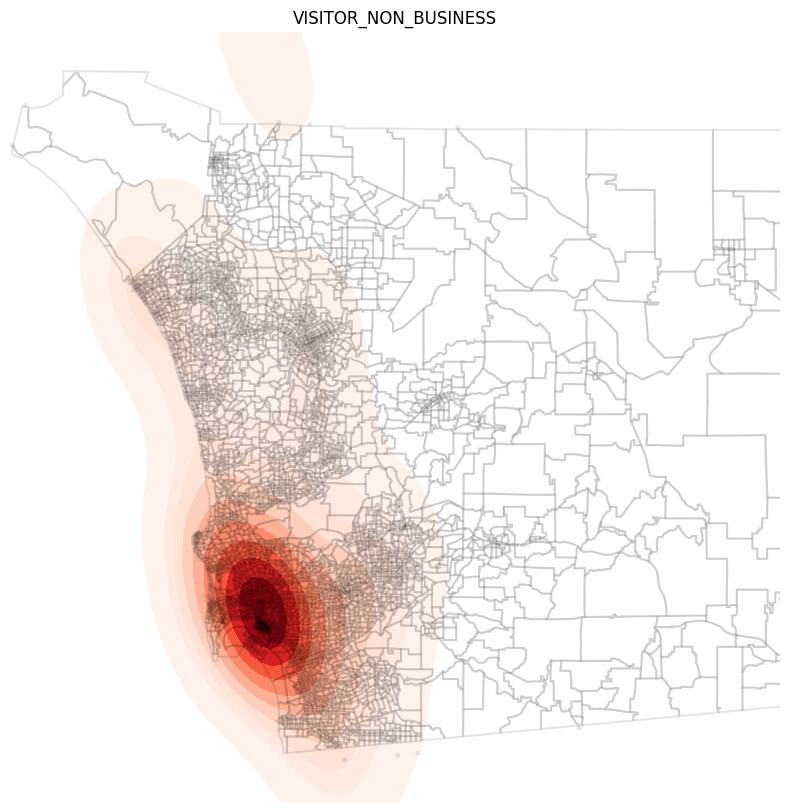

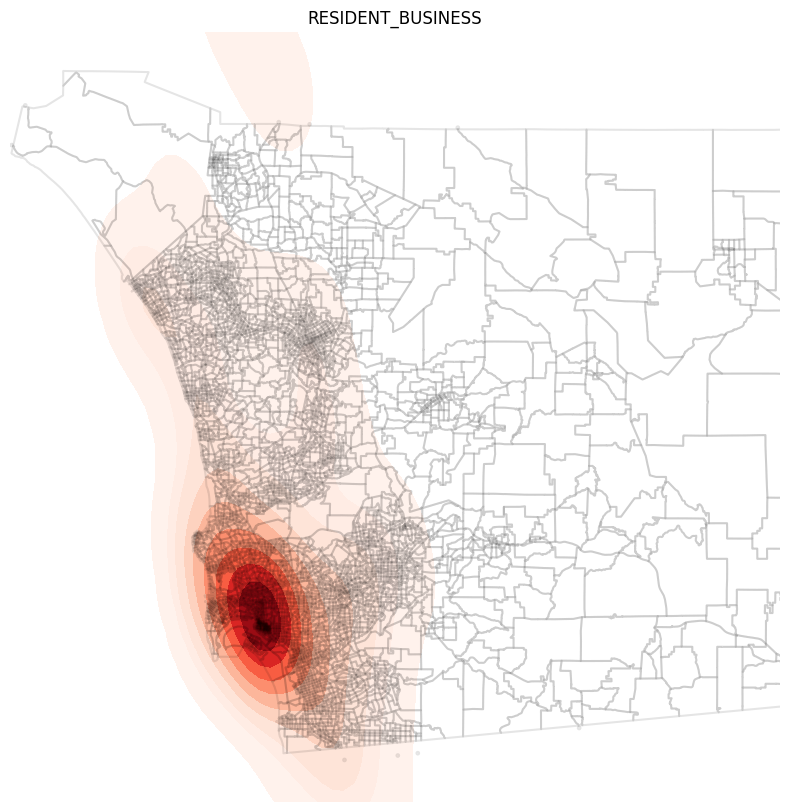

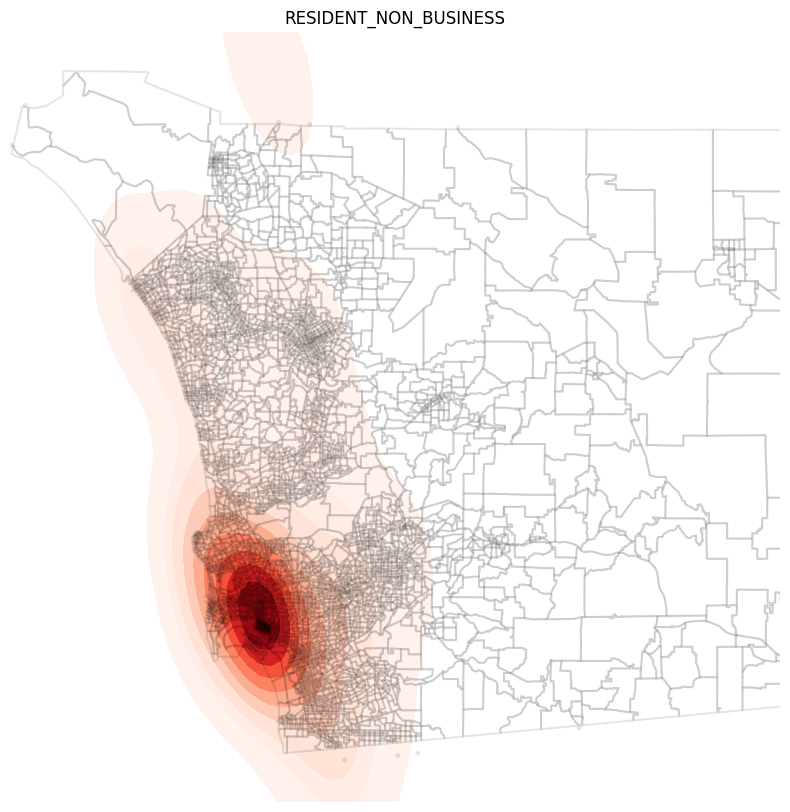

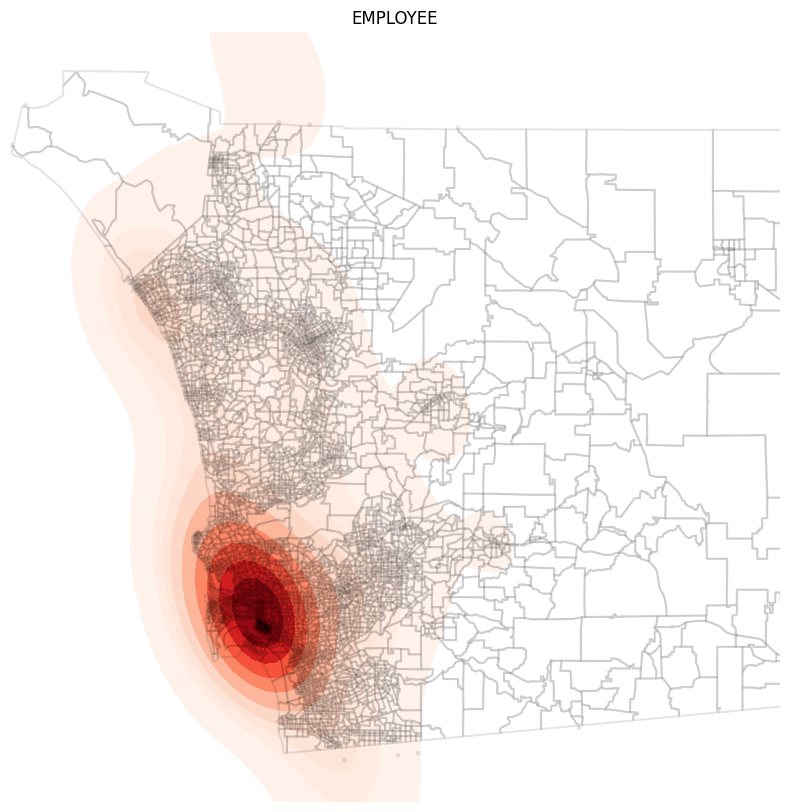

In [144]:
for purp in ['VISITOR_BUSINESS', 'VISITOR_NON_BUSINESS',
             'RESIDENT_BUSINESS', 'RESIDENT_NON_BUSINESS', 'EMPLOYEE']:

    _, ax = plt.subplots(figsize=(10, 10))

    geographies.boundary.plot(ax = ax, color = 'black', alpha = .1)
    glpt.kdeplot(
        survey_gdf.query(f'purpose_segment.str.upper() != "{purp}"'),
        weights = survey_gdf['weight_departing_only'],
        fill= True,
        thresh=.05,
        # levels= 30,
        cmap='Reds',
        ax = ax
    )

    plt.title(purp)
    plt.xlim((6.15e6,6.55e6))
    plt.ylim((1.75e6,2.15e6))
    plt.show()

## Clustering
https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means

## ANOVA
non-parametric - Kruskal 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal